# Product (100)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import copy
from IPython.display import Image
from qutip import *
import time

import pickle

In [ ]:
dim = 2      # number of levels for each qubit
GHz = 1e8    #1e9 (0.1GHz)
ns = 1e-9
b = destroy(dim)                     # sigma minus operator

s0m = tensor(b, qeye(dim))           # sigma minus on 0
s0p = tensor(b.dag(), qeye(dim))     # sigma plus on 0
s1m = tensor(qeye(dim), b)           # sigma minus on 1
s1p = tensor(qeye(dim), b.dag())     # sigma plus on 1

omega = [2*np.pi*5.0*GHz, 2*np.pi*5.2*GHz]            # qubit transition frequencies [rad/s]
Delta = [2*np.pi*0*GHz,2*np.pi*0*GHz] #[-.33, -.33]   # anharmonicities [rad/s]
Omega = [2*np.pi*1*GHz, 2*np.pi*1.1*GHz]              # control-qubit drive strength [rad/s]
J = 2*np.pi*0.3*GHz                                     # passive interaction [rad/s]

c_max = 10  # upper bound for control amplitudes
c_min = -10   # lower bound for control amplitudes
T = 10*ns   # target time
L = 10     # number of piecewise constants (at most 20)

H0 = ( omega[0]*s0p*s0m + omega[1]*s1p*s1m ) + \
     (1/2)*( Delta[0]*s0p*s0p*s0m*s0m + Delta[1]*s1p*s1p*s1m*s1m ) + \
     J*(s0p*s1m+s0m*s1p)

Hc0m = Omega[0]*(s0m)
Hc1m = Omega[1]*(s1m)
Hc0p = Omega[0]*(s0p)
Hc1p = Omega[1]*(s1p)

# Piecewise Constant Control on qubit 0
def C0(t, args):
    c = args['c']     # list of control parameters [c11,...,c1L]
    T = args['T']     # target time 
    L = args['L']     # L pieces
    t_inv = list(np.linspace(0,T,L+1))     # endpoints of time interval
    return( np.sum([c[0][i] * ( float(t>=t_inv[i] and t<t_inv[i+1]) ) for i in range(L)])+c[0][L-1]*float(t==t_inv[L])  )

def C1(t, args):
    c = args['c']     # list of control parameters [c21,...,c2L]
    T = args['T']     # target time 
    L = args['L']     # L pieces
    t_inv = list(np.linspace(0,T,L+1))     # endpoints of time interval
    return( np.sum([c[1][i] * ( float(t>=t_inv[i] and t<t_inv[i+1]) ) for i in range(L)])+c[1][L-1]*float(t==t_inv[L])  )

# Piecewise Constant Control on qubit 1
def C2(t, args):
    c = args['c']     # list of control parameters [c31,...,c3L]
    T = args['T']     # target time 
    L = args['L']     # L pieces
    t_inv = list(np.linspace(0,T,L+1))     # endpoints of time interval
    return( np.sum([c[2][i] * ( float(t>=t_inv[i] and t<t_inv[i+1]) ) for i in range(L)])+c[2][L-1]*float(t==t_inv[L])  )

def C3(t, args):
    c = args['c']     # list of control parameters [c41,...,c4L]
    T = args['T']     # target time 
    L = args['L']     # L pieces
    t_inv = list(np.linspace(0,T,L+1))     # endpoints of time interval
    return( np.sum([c[3][i] * ( float(t>=t_inv[i] and t<t_inv[i+1]) ) for i in range(L)])+c[3][L-1]*float(t==t_inv[L])  )

# Marker
def ep0(t, args):
    omega = args['omega']
    return np.exp(1j *omega[0]*t)

def em0(t, args):
    omega = args['omega']
    return np.exp(-1j *omega[0]*t)

def ep1(t, args):
    omega = args['omega']
    return np.exp(1j *omega[1]*t)

def em1(t, args):
    omega = args['omega']
    return np.exp(-1j *omega[1]*t)

# Control Functions C_i_j_k: i=0,1; j=m,p related to sm/sp; k=m,p related to (sm-sp) or (sm+sp)
def C0mm(t, args):
    return 1j*C0(t, args)*ep0(t, args)
def C0pm(t, args):
    return -1j*C0(t, args)*em0(t, args)

def C0mp(t, args):
    return C1(t, args)*ep0(t, args)
def C0pp(t, args):
    return C1(t, args)*em0(t, args)

def C1mm(t, args):
    return 1j*C2(t, args)*ep1(t, args)
def C1pm(t, args):
    return -1j*C2(t, args)*em1(t, args)

def C1mp(t, args):
    return C3(t, args)*ep1(t, args)
def C1pp(t, args):
    return C3(t, args)*em1(t, args)

# Total Hamiltonain
H = [H0, [Hc0m,C0mm], [Hc0p,C0pm], [Hc0m,C0mp], [Hc0p,C0pp], [Hc1m,C1mm], [Hc1p,C1pm], [Hc1m,C1mp], [Hc1p,C1pp]]   

In [ ]:
GA = sigmax() # Target Unitary on qubit 0
GB = sigmax() # Target Unitary on qubit 1

In [4]:
def OBJ(c,T,L,omega,H,GA,GB):
    
    args = {
        'c': c,
        'T': T,
        'L': L,
        'omega': omega
    }
    
    U = propagator(H, T, args=args,options=Options(nsteps=1700))
    
    # SVD for partial traces
    sigma = np.sqrt((((tensor(GA,qeye(dim)).dag()*U).ptrace(1))*((tensor(GA,qeye(dim)).dag()*U).ptrace(1)).dag()).eigenstates()[0])
    lambd = np.sqrt((((tensor(qeye(dim),GB).dag()*U).ptrace(0))*((tensor(qeye(dim),GB).dag()*U).ptrace(0)).dag()).eigenstates()[0])
    
    # product of fidelity
    return (sum(sigma)/(dim**2)) * (sum(lambd)/(dim**2))

In [5]:
# GRadient Ascent Pulse Engineering (GRAPE)

def GRAPE(T,L,omega,H,GA,GB):
    eps = 0.01  # ascending rate
    threshold = 0.00001  # if cost changes less than threshold, then halt
    itera_max = 1000     # max iteration number
    count = 0           # counting iterations
    diff_cost = np.inf  # initial cost difference
    d = T/L             # time interval length
    record_cost = []

    # Step1-1, Guess initial
    c = [[float(np.random.uniform(c_min,c_max)) for _ in range(L)],    # for C1
         [float(np.random.uniform(c_min,c_max)) for _ in range(L)],    # for C2
         [float(np.random.uniform(c_min,c_max)) for _ in range(L)],    # for C3
         [float(np.random.uniform(c_min,c_max)) for _ in range(L)]]    # for C4

    # Step1-2, Compute initial cost
    cost = OBJ(c,T,L,omega,H,GA,GB)
    record_cost.append(cost)


    # Start while loop
    while (count<=itera_max) and (diff_cost>threshold):   
        count += 1
    
        # Step 2, compute derivative numerically by Df(x0) = (f(x0+dx)-f(x0)) / dx
        dx = 0.01
        D_J_c = [ [ 0 for l in range(L)] for m in range(4)]
        for m in range(4):
            for l in range(L):
                c_tmp = copy.deepcopy(c)
                c_tmp[m][l] += dx
                D_J_c[m][l] += (OBJ(c_tmp,T,L,omega,H,GA,GB) - OBJ(c,T,L,omega,H,GA,GB)) / dx
    
        # Step 3, normalization for gradient
        norm2_D = 0
        for m in range(4):
            for l in range(L):
                norm2_D += D_J_c[m][l]**2
            
        norm_D = np.sqrt(norm2_D)
    
        D_J_c = [[ eps*D_J_c[m][l]/norm_D for l in range(L)] for m in range(4)]
    
        # Step4, gradient ascend
        c = np.array(c) + np.array(D_J_c)    
     
    
        # Step5, Compute cost 
        new_cost = OBJ(c,T,L,omega,H,GA,GB)
        if new_cost > record_cost[-1]:
            record_cost.append(new_cost)
            diff_cost = record_cost[-1] - record_cost[-2]
            eps = min(eps+0.01,0.09)   # set upper bound for the learning rate
        else:
            eps = 0.01
            # Repeat Step 2, compute derivative numerically by Df(x0) = (f(x0+dx)-f(x0)) / dx
            dx = 0.01
            D_J_c = [ [ 0 for l in range(L)] for m in range(4)]
            for m in range(4):
                for l in range(L):
                    c_tmp = copy.deepcopy(c)
                    c_tmp[m][l] += dx
                    D_J_c[m][l] += (OBJ(c_tmp,T,L,omega,H,GA,GB) - OBJ(c,T,L,omega,H,GA,GB)) / dx
    
            # Repeat Step 3, normalization for gradient
            norm2_D = 0
            for m in range(4):
                for l in range(L):
                    norm2_D += D_J_c[m][l]**2
            
            norm_D = np.sqrt(norm2_D)
    
            D_J_c = [[ eps*D_J_c[m][l]/norm_D for l in range(L)] for m in range(4)]
    
            # Repeat Step4, gradient ascend
            c = np.array(c) + np.array(D_J_c)    
     
    
            # Repeat Step5, Compute cost 
            new_cost = OBJ(c,T,L,omega,H,GA,GB)
            record_cost.append(new_cost)
            diff_cost = record_cost[-1] - record_cost[-2]

    return record_cost, c
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


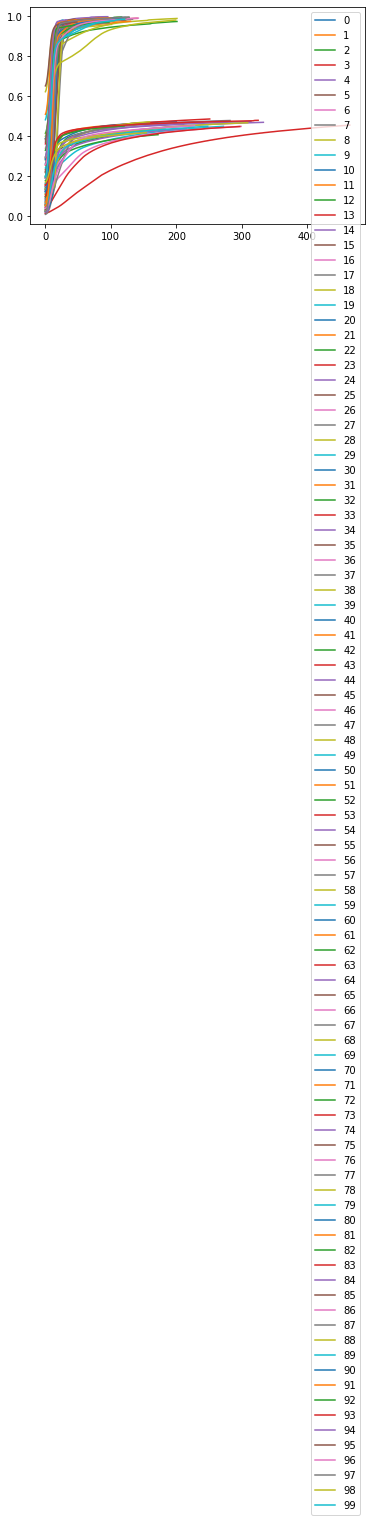

In [13]:
record_c = []
record_f = {}
n_trails = 100
start_time = time.time()
for i in range(n_trails): # apply GRAPE with random initial multiple times
    print(i)
    fidelity,c = GRAPE(T,L,omega,H,GA,GB)
    record_c.append(c)
    record_f.update({i:fidelity})
    with open("2023_GRAPE_product.bin", "wb") as f:
        pickle.dump([record_c, record_f], f)
    plt.plot(fidelity)
    
end_time = time.time()
plt.legend([str(i) for i in range(n_trails)])
plt.show()
print(end_time-start_time)

In [14]:
print(end_time)

1696455821.1616356


In [18]:
with open("2023_GRAPE_product.bin", "rb") as f:
    rec_c, rec_f= pickle.load(f)
    print(rec_c)


[array([[  8.04563569,   8.006116  ,   5.57174241,   7.30810537,
          8.45895909,   2.9965602 ,   3.00051995,   9.58672547,
         -7.51206323,   8.94861131],
       [  1.3715318 ,   7.9550453 ,  -5.43738566,   6.85297258,
          6.71861876,   8.42080043,   0.49068004,  -7.94022249,
          7.9313779 ,   5.21918778],
       [ -3.92140117,  -8.61241866,   5.07113972,   5.29640505,
          1.63548711,   7.8740569 ,  -9.14464228,  -8.57669898,
         -2.63505987,  -4.69140897],
       [  0.47495229, -10.05395788,   6.50360817,   4.48399161,
          1.77341642,  -5.81788683,  -0.56263907,   9.04436923,
         -2.10442789,  -2.37175027]]), array([[-4.27156254,  3.68753999, -5.61993583,  0.2263028 , -5.58947293,
        -4.80156104, -7.40834608, -8.69875284, -6.82654392,  2.40339058],
       [ 0.82308734,  0.10537991, -8.00077004, -0.51478624,  5.55299168,
        -4.8257348 ,  5.64991121, -0.67072837,  6.73038004, -3.20781394],
       [ 5.9665927 , -7.55827457,  6.574944

In [19]:
print(rec_f)

{0: [0.025451172577434365, 0.03373871266672239, 0.05051364046538726, 0.07550455246516477, 0.1090204453159296, 0.15091205992883272, 0.2014458584912908, 0.26045523665394016, 0.32760195160561784, 0.40225812303801173, 0.47578258566867476, 0.54595268240272, 0.6131804083748136, 0.6761938243161976, 0.7339444742392898, 0.7857635316095711, 0.8309819625512815, 0.8691871075241911, 0.9004077771830998, 0.924637318485016, 0.9424797064810396, 0.9544713732693241, 0.9615201042816555, 0.9653174980674644, 0.9682068162463833, 0.9678409079869573], 1: [0.1121533158686618, 0.1150521038402377, 0.12076787478821145, 0.12934322425880945, 0.1404914466780909, 0.1542311127948863, 0.17022849114627545, 0.18803566053742002, 0.2071110850073378, 0.22678028261466482, 0.24440498052361817, 0.2600232206145528, 0.2737129772645808, 0.2856078133103976, 0.29586908187960326, 0.30466238028142145, 0.31216997759743886, 0.31861852344117164, 0.3242588534732722, 0.3293009471870321, 0.33402438411391494, 0.338471948714521, 0.34273708046

26
[26, 131, 141, 102, 76, 109, 111, 106, 102, 49, 202, 80, 82, 101, 97, 134, 115, 105, 21, 123, 26, 76, 82, 62, 122, 86, 128, 108, 102, 118, 112, 101, 33, 118, 89, 119, 91, 117, 112, 39, 202, 25, 26, 131, 91, 121, 21, 98, 126, 27, 121, 90, 96, 46, 112, 21, 103, 28, 123, 99, 129, 64, 99, 83, 52, 200, 118, 101, 98, 33, 49, 143, 129, 122]
94.33783783783784
40.93114753544418
[160, 184, 159, 172, 231, 273, 173, 466, 334, 300, 201, 190, 252, 315, 160, 216, 221, 283, 298, 264, 310, 121, 229, 249, 326, 155]
240.07692307692307
75.11320844458875


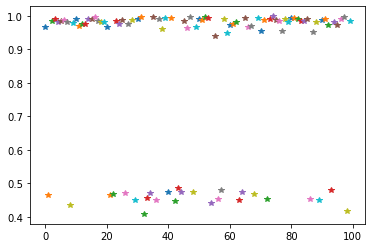

In [39]:
with open("2023_GRAPE_product.bin", "rb") as f:
    rec_c, rec_f= pickle.load(f)

lists = sorted(rec_f.items())
x, y = zip(*lists) 
count = 0
conv_u = []
conv_l = []

for i in range(n_trails):
    p_y = y[i]
    if p_y[-1]<0.71:
        count += 1
        conv_l.append(len(p_y))
    else:
        conv_u.append(len(p_y))
    plt.plot(x[i],p_y[-1],'*')
    
print(count)
print(conv_u)
print(np.mean(conv_u))
print(np.std(conv_u))
print(conv_l)
print(np.mean(conv_l))
print(np.std(conv_l))

In [ ]:
print(1
    )

In [2]:
print(end_time-start_time)

NameError: name 'end_time' is not defined